In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import skewnorm
from ll_xy import lonlat_to_xy
from scipy.stats import linregress
import datetime
import string
import cartopy
import tools
import cartopy.crs as ccrs
import pandas as pd
pd.set_option("mode.chained_assignment", None)

dep_l = pickle.load(open('../pickles/line_depths_dict.p','rb'))
statistics = pickle.load(open('../pickles/statistics.p','rb'))

paths = pickle.load(open('../pickles/sloops.p','rb'))


Index(['Date/Time', ' Lon', ' Lat', ' local X', ' Local Y', ' Snow Depth (m)',
       ' Ice Thickness 18kHz ip (m)', ' Ice Thickness 5kHz ip (m)',
       ' Ice Thickness 93kHz ip (m)', 'Unnamed: 9'],
      dtype='object')


(array([ 2.5,  7.5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5,
        57.5, 62.5, 67.5, 72.5, 77.5]),
 array([0.04488778, 0.39650873, 0.37531172, 0.12718204, 0.03865337,
        0.01371571, 0.00249377, 0.00124688, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]),
 array([4.76269974e-02, 3.72413445e-01, 3.71499162e-01, 1.59741195e-01,
        4.17938134e-02, 6.73642511e-03, 6.68932611e-04, 4.09233001e-05,
        1.54239044e-06, 3.58140472e-08, 5.12327743e-10, 4.51520782e-12,
        2.45156274e-14, 8.20056314e-17, 1.68997290e-19, 2.14561205e-22]))

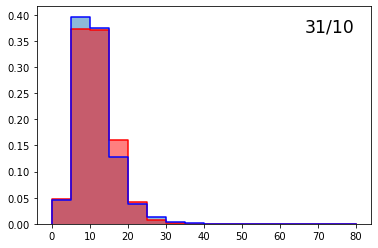

In [11]:
def compare_magna(df,ax=None,impose_y = False,anno=False,season='all'):
    
    if impose_y: df = df[df[' local X'] < 5000]

    bw = 5
    
    bin_edges = np.arange(0,81,bw)


    mean_magna = np.nanmean(df[' Snow Depth (m)'])*100

    ##################################################

    bc, ft = tools.depth_distribution_from_depth(mean_magna,bin_edges,statistics=statistics['all'])

    hist, bin_edges = np.histogram(np.array(df[' Snow Depth (m)'])*100,bins=bin_edges, density=True)
    
    rmse = np.round(np.sqrt(np.mean(np.square(ft-(hist*bw)))),decimals=2)

    if ax == None: fig, ax  = plt.subplots(1,1)
        
        
    if anno:
    
        dt = datetime.datetime.strptime(df['Date/Time'][0],"%Y-%m-%dT%H:%M:%S")
    
        month = dt.date().month; day = dt.date().day
        ax.annotate(text=f'{day}/{month}',xy=(0.95,0.95),ha='right',va='top',xycoords='axes fraction',fontsize='xx-large')

    ax.step([0]+list(bc+bw/2),[0]+list(ft),color='r',)
    ax.step([0]+list(bc+bw/2), [0]+list(hist*bw),color='b')
    
    alpha=0.5
    
    t = ax.bar(bc, hist*bw,
             width=bw,
             alpha=alpha,
             color='#1f77b4',
              label='Transect')

    m = ax.bar(bc, ft,
             width=bw,
             alpha=alpha,
             color='r',
              label='Model')
    
#     ax.legend(loc='center right')
    
    return(bc, hist*bw, ft)
    

df = pd.read_csv(paths[0])

print(df.columns)

compare_magna(df, ax=None, impose_y=True,anno=True,season='winter')

In [8]:
print(len(paths))

17


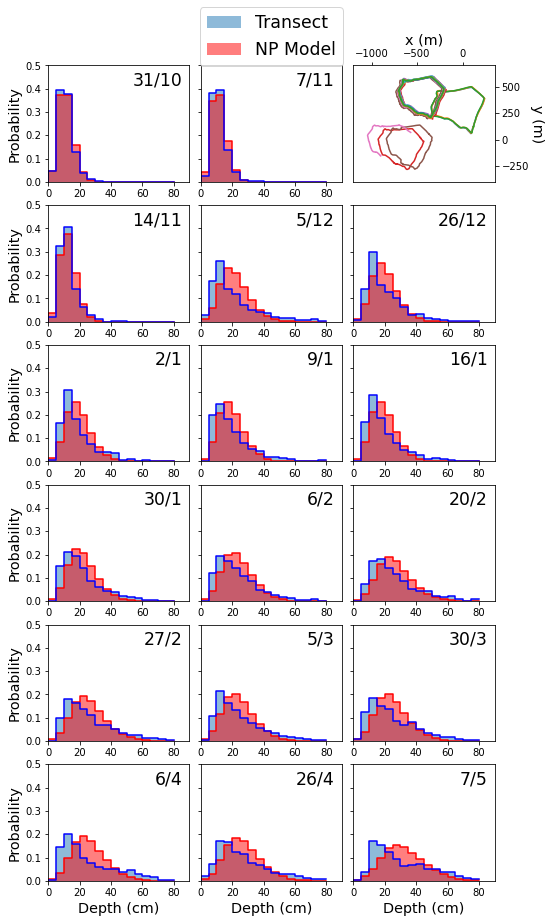

In [22]:
per_cm = r'cm$^{-1}$'


ncols = 3
         
fig, axs = plt.subplots(6,ncols,figsize=(8,15))

thin_snow_fit, thin_snow_obs = [], []

for path, ax in zip(paths, list(axs.reshape(-1))[:ncols-1]+list(axs.reshape(-1))[ncols:]):
    df = pd.read_csv(path)

    bc, obs, fit = compare_magna(df, ax=ax, impose_y=False,anno=True)
    ax.set_ylim(0,0.5)
    
    ax.set_xticks(np.arange(0,81,20))
    ax.set_xlim(0,90)
    
    thin_snow_fit.append(np.mean(fit[0:2]))
    thin_snow_obs.append(np.mean(obs[0:2]))

    
for ax in list(axs.reshape(-1))[-ncols:]:
    ax.set_xlabel('Depth (cm)', fontsize='x-large')
for ax in list(axs.reshape(-1))[::ncols]:
    ax.set_ylabel(f'Probability', fontsize='x-large') # This is probability, not prob dens!

for counter, ax in enumerate(axs.reshape(-1)):
    if (counter %ncols != 0) & (counter != ncols-1):
        ax.set_yticklabels([])    

ax = axs.reshape(-1)[ncols-1]
for path in paths:
    df = pd.read_csv(path)
#     df = df[df[' Local Y'] < 0]
    ax.set_xlim(-1200,350)
    ax.set_ylim(-400,700)
    ax.plot(df[' local X'],df[' Local Y'])
    

ax.set_xlabel('x (m)',fontsize='x-large')
ax.set_ylabel('y (m)',fontsize='x-large',rotation=270,labelpad=15)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
ax.yaxis.set_label_position("right")
ax.xaxis.set_label_position("top")


        
ax = axs.reshape(-1)[1]
l1 = ax.bar(range(1),range(1),color='#1f77b4',alpha=0.5)
l2 = ax.bar(range(1),range(1),color='r',alpha=0.5)

ax.legend(handles=[l1,l2],labels=['Transect','NP Model'],
                           bbox_to_anchor=(0.5,1.25),
                           loc='center',fontsize='xx-large')
        
plt.subplots_adjust(wspace=0.08)    

plt.savefig('../figures/fig5_sloop.png', bbox_inches='tight',dpi=500)    
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/fig5_sloop.png', bbox_inches='tight',dpi=500)    

plt.show()

In [24]:
transect_count = 0

stds = []
mean = []
t_lengths = []
norms = []
dates = []

for key in dep_l:
    
    station = dep_l[key]
    
    for date in station:

        transect_count += 1

        series = np.array(list(station[date]))

        n_series = (series - np.nanmean(series))

        std = np.nanstd(n_series)

        ns_series = n_series/std

        stds.append(std)
        mean.append(np.nanmean(series))
        norms.append(ns_series)

        dates.append(date)
        t_lengths.append(len(series[~np.isnan(series)]))

8.061807955408456
0.9980120046689749
1.0


/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()
/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


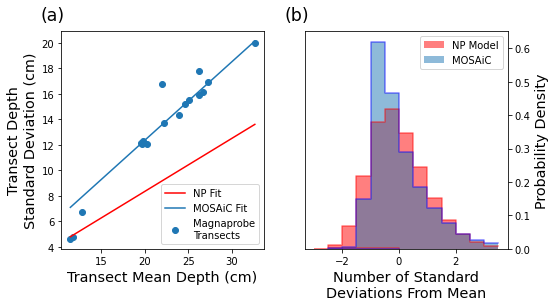

In [26]:
md = []
ms = []
normed = []

for path in paths:
    df = pd.read_csv(path)
    mean_depth = np.nanmean(df[' Snow Depth (m)'])*100
    stdv_depth = np.nanstd(df[' Snow Depth (m)'])*100
    md.append(mean_depth)
    ms.append(stdv_depth)
    normed.append(    (np.array(df[' Snow Depth (m)'])*100 - mean_depth)/stdv_depth   )
    
a, loc, scale = skewnorm.fit(np.concatenate(normed))
print(a)
    
stats = np.linalg.lstsq(np.array(mean)[:,np.newaxis],stds)

magna_stats = np.linalg.lstsq(np.array(md)[:,np.newaxis],ms)

magna_linear_prediction = np.array([np.min(md),np.max(md)])*magna_stats[0][0]



fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

ax1.scatter(md,ms, label='Magnaprobe\nTransects')

linear_prediction = np.array([np.min(md),np.max(md)])*statistics['all']['stats']
ax1.plot([np.min(md),np.max(md)], linear_prediction, color='r', label = 'NP Fit')

# linear_prediction = np.array([np.min(md),np.max(md)])*statistics['winter']['stats']
# ax1.plot([np.min(md),np.max(md)], linear_prediction, color='r', label = 'NP Winter Fit', ls = '--')

ax1.plot([np.min(md),np.max(md)], magna_linear_prediction, color='#1f77b4', label='MOSAiC Fit')

ax1.set_ylabel('Transect Depth\nStandard Deviation (cm)', fontsize='x-large')
ax1.set_xlabel('Transect Mean Depth (cm)', fontsize='x-large')


all_norms = np.concatenate(normed)


bin_edges = np.arange(-3,4,0.5)
bin_centres = np.array([x+0.25 for x in bin_edges[:-1]])

season = 'winter'
fit = skewnorm.pdf(bin_centres,
                   statistics[season]['a'],
                   statistics[season]['loc'],
                   statistics[season]['scale'])



ax2.bar(x=bin_centres,height=fit,width=0.5,alpha=0.5,color='r', label='NP Model')

hist, bc = np.histogram(all_norms, bin_edges,density=True)

ax2.bar(bin_centres, hist,alpha=0.5,width=0.5, label = 'MOSAiC')

bw=0.5

ax2.step([0]+list(bin_centres+bw/2),[0]+list(fit),color='r',alpha=0.5)
ax2.step([0]+list(bin_centres+bw/2), [0]+list(hist),color='b',alpha=0.5)

ax2.set_ylabel(r'Probability Density', fontsize='x-large')
ax2.set_xlabel('Number of Standard\nDeviations From Mean', fontsize='x-large')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

print(np.sum(fit)*bw)
print(np.sum(hist)*bw)

ax1.legend()
ax2.legend()


ax1.annotate(text='(a)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')
ax2.annotate(text='(b)', fontsize='xx-large', xy=(-0.1,1.05), xycoords= 'axes fraction')

plt.savefig('../figures/fig4_sloop.png', bbox_inches='tight',dpi=500)
plt.savefig('/home/robbie/Dropbox/Apps/Overleaf/sub-km-snow-depth-dist/fig4_sloop.png', bbox_inches='tight',dpi=500)

pickle.dump(all_norms, open('../pickles/mosaic_all_norms_sloop.p','wb'))

(0.001606308895591682, 0.018732144264312488, 0.02033845315990417)

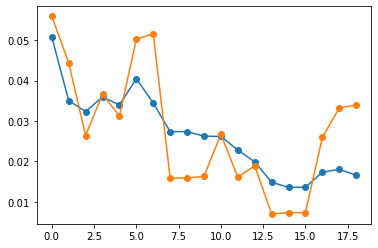

In [33]:
plt.plot(thin_snow_fit,marker='o')
plt.plot(thin_snow_obs,marker='o')

errors = np.array(thin_snow_fit) - np.array(thin_snow_obs)



np.mean(errors[:7]), np.mean(thin_snow_obs[:7]),np.mean(thin_snow_fit[:7])

np.mean(errors[7:]), np.mean(thin_snow_obs[7:]),np.mean(thin_snow_fit[7:])

../MOSAiC_transects/PS122-1_8-58-magnaprobe-transect-20191121-PS122-1_8-58-20191121-UTC-6.csv


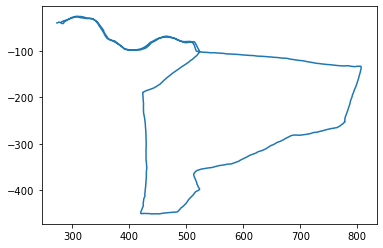

../MOSAiC_transects/PS122-2_25-119-ANJA_43_Nloop-20200220-UTC-0.csv


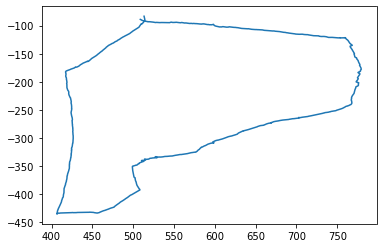

../MOSAiC_transects/PS122-1_5-27-magnaprobe-transect-20191031-PS122-1_5-27-20191030-UTC-6.csv


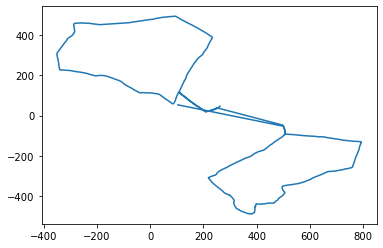

../MOSAiC_transects/PS122-1_6-50-magnaprobe-transect-20191107-PS122-1_6-50-20191106-UTC-6.csv


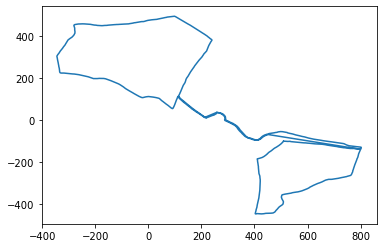

../MOSAiC_transects/PS122-2_19-110-ANJA_28-20200109-UTC-0.csv


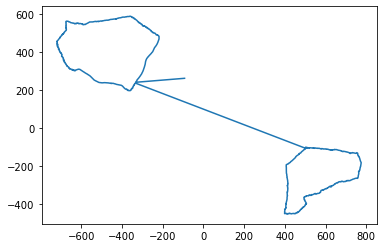

../MOSAiC_transects/PS122-2_22-92-ANJA_38_Nloop-20200130-UTC-0.csv


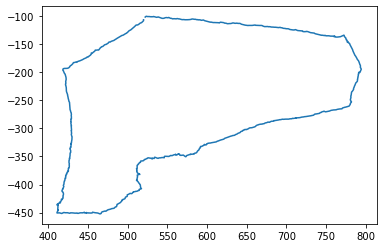

../MOSAiC_transects/mcs_polona


IsADirectoryError: [Errno 21] Is a directory: '../MOSAiC_transects/mcs_polona'

In [34]:
import os
def plot_magna_track(path):
    df = pd.read_csv(path)
    plt.plot(df['xc'],df['yc'])
    plt.show()

magna_dir = '../MOSAiC_transects' 
    
magna_files = os.listdir(magna_dir)

for file in magna_files:
    path = magna_dir + '/' + file
    print(path)
    plot_magna_track(path)
